***
# Univeral Training Data Augmentation
***

*Correspondence to: felix.wagner@oeaw.ac.at*

In this notebook we explore the data augmentation module of the Cait Python package.

We create here a universal training set, to identify particle recoils and empty noise baselines against artifacts. In the second section of the notebook, we train a classifier model to perform this task.

In [1]:
from cait.augment import ParameterSampler, plot_events, unfold, L2
import numpy as np
import cait as ai  # install from the develop branch
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from tqdm.auto import tqdm
from scipy import signal
from cait.models import CNNModule
from torchvision import transforms
from cait.datasets import SingleMinMaxNorm, DownSample, ToTensor, CryoDataModule
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

%config InlineBackend.figure_formats = ['svg']

Some definitions for the plots.

In [2]:
mpl.rcParams['figure.figsize'] = (7.2, 4.45)
mpl.rcParams['savefig.dpi'] = 300

## Data Augmentation

Define the global parameters. For details, see the notebook `Cryogenic detector data augmentation`.

For the whole notebook: Only capitalized parameters need to be set by the user.

In [3]:
RECORD_LENGTH = 16384
SAMPLE_FREQUENCY = 25000

POLYNOMIAL_DRIFTS = True
RASTERIZE = False
SQUARE_WAVES = False
SATURATION = True
CLASS_NAMES = ['Event Pulse',
               'Noise',
               'Decaying Baseline',
               'Temperature Rise',
               'Spike',
               'Squid Jump',
               'Reset',
               'Cosinus Tail',
               'Decaying Baseline with Event Pulse',
               'Pile Up',
               'Early or late Trigger',
               ]


# ----------------------------------------- 
# no need to change below parameters
# ----------------------------------------- 

label_names = {
    'unlabeled': 0,
    'Event Pulse': 1,
    'Test/Control Pulse': 2,
    'Noise': 3,
    'Squid Jump': 4,
    'Spike': 5,
    'Early or late Trigger': 6,
    'Pile Up': 7,
    'Carrier Event': 8,
    'Strongly Saturated Event Pulse': 9,
    'Strongly Saturated Test/Control Pulse': 10,
    'Decaying Baseline': 11,
    'Temperature Rise': 12,
    'Stick Event': 13,
    'Square Waves': 14,
    'Human Disturbance': 15,
    'Large Sawtooth': 16,
    'Cosinus Tail': 17,
    'Light only Event': 18,
    'Ring & Light Event': 19,
    'Sharp Light Event': 20,
    'Reset': 21,
    'Decaying Baseline with Event Pulse': 22,
    'Decaying Baseline with Tail Event': 23,
    'unknown/other': 99,
}

We define the sampler class.

In [4]:
parsam = ParameterSampler(record_length=RECORD_LENGTH,
                          sample_frequency=SAMPLE_FREQUENCY)

Plot some augmented events. We did not define the baseline resolution, pulse shapes, saturation curve or noise power spectrum. Therefore for every batch, a new one is sampled, making the data overally more diverse.

Sample Noise...



Sample Polynomials...



Sample Pulse Nmbr  0
Sample Saturation ...



Event Pulse


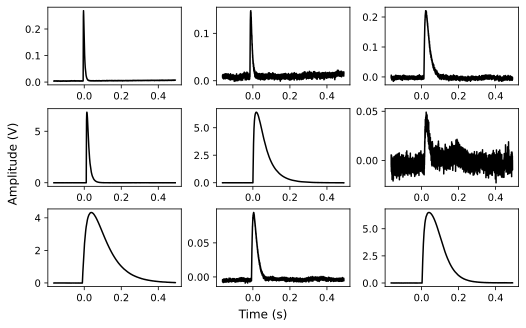

Resolution (only meaningful without Saturation):  1.1077452839101551


In [5]:
NMBR_PLOTS = 1

# classes = np.random.choice(CLASS_NAMES, size=NMBR_PLOTS)
classes = [CLASS_NAMES[0] for i in range(NMBR_PLOTS)]

for i in range(NMBR_PLOTS):

    event, info = parsam.get_event(label=classes[i],
                                   size=9,
                                   rasterize=RASTERIZE,
                                   poly=POLYNOMIAL_DRIFTS,
                                   square=SQUARE_WAVES,
                                   saturation=SATURATION,
                                   verb=True,
                                   )

    print(classes[i])
    plot_events(event, t=parsam.t)
    if classes[i] == 'Event Pulse':
        print('Resolution (only meaningful without Saturation): ', np.std(np.abs(np.max(event, axis=1) - info['pulse_height'])))

Now create the HDF5 data set.

In [7]:
FNAME = 'test_data/universal_v0_1.h5'
IDX = list(range(11))  # which to take from the class names
BATCHSIZE = 50
EVENTS_PER_CLASS = {  # use always multiple of batch size!
    'Event Pulse': 2000,
    'Noise': 1000,
    'Decaying Baseline': 150,
    'Temperature Rise': 150,
    'Spike': 150,
    'Squid Jump': 150,
    'Reset': 300,
    'Cosinus Tail': 500,
    'Decaying Baseline with Event Pulse': 500,
    'Pile Up': 1000,
    'Early or late Trigger': 500,
}
DIV = 1
TOTAL_EVENTS = int(np.sum(list(EVENTS_PER_CLASS.values()))/DIV)
BATCHSIZE = int(BATCHSIZE/DIV)

# -------------------------------------------
# no changes required below this line!
# -------------------------------------------

with h5py.File(FNAME, 'w') as f:
    f.require_group('events')
    f['events'].create_dataset('event',
                                shape=(1, TOTAL_EVENTS, RECORD_LENGTH),
                                dtype=np.float32)
    f['events'].create_dataset('labels',
                                shape=(1, TOTAL_EVENTS),
                                dtype=int)
    f['events'].create_dataset('true_ph',
                                shape=(1, TOTAL_EVENTS),
                                dtype=float)
    f['events'].create_dataset('true_onset',
                                shape=(TOTAL_EVENTS, ),
                                dtype=float)

    bar = tqdm(total=TOTAL_EVENTS)
    bcount = 0

    for i in IDX:

        bar.write('Simulating {} ...'.format(CLASS_NAMES[i]))

        nmbr_events = int(EVENTS_PER_CLASS[CLASS_NAMES[i]] / DIV)
        batches = int(nmbr_events / BATCHSIZE)

        for b in range(batches):
            event, info = parsam.get_event(label=CLASS_NAMES[i],
                                           size=BATCHSIZE,
                                           rasterize=RASTERIZE,
                                           poly=POLYNOMIAL_DRIFTS,
                                           square=SQUARE_WAVES,
                                           saturation=SATURATION,
                                           verb=False,
                                           )

            f['events']['event'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), :] = event
            f['events']['labels'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = label_names[CLASS_NAMES[i]]
            f['events']['true_ph'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['pulse_height']
            f['events']['true_onset'][int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['t0']*1000

            # attributes

            f['events']['labels'].attrs.create(name='unlabeled', data=0)
            f['events']['labels'].attrs.create(name='Event_Pulse', data=1)
            f['events']['labels'].attrs.create(name='Test/Control_Pulse', data=2)
            f['events']['labels'].attrs.create(name='Noise', data=3)
            f['events']['labels'].attrs.create(name='Squid_Jump', data=4)
            f['events']['labels'].attrs.create(name='Spike', data=5)
            f['events']['labels'].attrs.create(name='Early_or_late_Trigger', data=6)
            f['events']['labels'].attrs.create(name='Pile_Up', data=7)
            f['events']['labels'].attrs.create(name='Carrier_Event', data=8)
            f['events']['labels'].attrs.create(name='Strongly_Saturated_Event_Pulse', data=9)
            f['events']['labels'].attrs.create(name='Strongly_Saturated_Test/Control_Pulse', data=10)
            f['events']['labels'].attrs.create(name='Decaying_Baseline', data=11)
            f['events']['labels'].attrs.create(name='Temperature_Rise', data=12)
            f['events']['labels'].attrs.create(name='Stick_Event', data=13)
            f['events']['labels'].attrs.create(name='Square_Waves', data=14)
            f['events']['labels'].attrs.create(name='Human_Disturbance', data=15)
            f['events']['labels'].attrs.create(name='Large_Sawtooth', data=16)
            f['events']['labels'].attrs.create(name='Cosinus_Tail', data=17)
            f['events']['labels'].attrs.create(name='Light_only_Event', data=18)
            f['events']['labels'].attrs.create(name='Ring_Light_Event', data=19)
            f['events']['labels'].attrs.create(name='Sharp_Light_Event', data=20)
            f['events']['labels'].attrs.create(name='Reset', data=21)
            f['events']['labels'].attrs.create(name='Decaying_Baseline_with_Event_Pulse', data=22)
            f['events']['labels'].attrs.create(name='Decaying_Baseline_with_Tail_Pulse', data=23)
            f['events']['labels'].attrs.create(name='unknown/other', data=99)

            bar.update(BATCHSIZE)
            bcount += 1


Simulating Event Pulse ...
Simulating Noise ...
Simulating Decaying Baseline ...
Simulating Temperature Rise ...
Simulating Spike ...
Simulating Squid Jump ...
Simulating Reset ...
Simulating Cosinus Tail ...
Simulating Decaying Baseline with Event Pulse ...
Simulating Pile Up ...
Simulating Early or late Trigger ...


Lets look into the simulated data with the VizTool!

In [6]:
dh = ai.DataHandler(nmbr_channels=1,
              sample_frequency=SAMPLE_FREQUENCY,
              record_length=RECORD_LENGTH)
dh.set_filepath('test_data', 'universal_v0_1', appendix=False)

DataHandler Instance created.


First we calculate the main parameters and additional main paramters.

In [9]:
dh.calc_mp()
dh.calc_additional_mp(no_of=True)

CALCULATE MAIN PARAMETERS.
CALCULATE ADDITIONAL MAIN PARAMETERS.


Looks like a total mess, right?

In [7]:
datasets = {
    'Pulse Height Phonon (V)': ['pulse_height', 0, None],
    'Rise Time Phonon (ms)': ['rise_time', 0, None],
    'Decay Time Phonon (ms)': ['decay_time', 0, None],
    'Onset Phonon (ms)': ['onset', 0, None],
    'Slope Phonon (V)': ['slope', 0, None],
    'Variance Phonon (V^2)': ['var', 0, None],
    'Mean Phonon (V)': ['mean', 0, None],
    'Skewness Phonon': ['skewness', 0, None],
}

viz = ai.VizTool(path_h5='test_data/', 
              fname='universal_v0_1',
              group='events', 
              datasets=datasets, 
              nmbr_channels=1, 
              batch_size=1000,
              sample_frequency=25000,
              record_length=16384)
viz.set_colors(dh.get('events', 'labels')[0])
viz.show()

DataHandler Instance created.


## Universal Classification

Now we can train a univeral classifier model, which identifies particle recoils agains all kinds of artifacts, noise or pile up! We mostly use the same functions as in the 'Classification with Neural Network' Notebook, just this time we will use a CNN model.

We want to do a binary classification between events and other artifacts (noise, etc). Therefore we set all labels to 0 or 1, depending on if they show an event or not.

In [20]:
label_cuts = ai.cuts.LogicalCut(np.logical_or(dh.get('events', 'labels')[0] == 1, dh.get('events', 'labels')[0] == 17))
print(label_cuts.counts(), label_cuts.counts()/label_cuts.total())

2500 0.390625


In [21]:
dh.include_values(values=label_cuts.get_flag(),
                 naming='labels_binary', channel=0, type='events', delete_old=True)

Included values.


The cells below work very much the same way as they do for the other NN classification notebook.

In [34]:
# some parameters
# nmbr_gpus = ... uncommment and put in trainer to use GPUs
path_h5 = 'test_data/universal_v0_1.h5'
path_h5_test = 'test_data/test_v0_1.h5'
type = 'events'  # the group key for the data in the HDF5 set
keys = ['event', 'labels_binary']  # the datasets in the group from which we include data in the samples for the NN
channel_indices = [[0], [0]]  # the first indices of the datasets
feature_indices = [None, None]  # the third indices of the datasets
feature_keys = ['event_ch0']    # the keys in the samples of the NN dataset that are input to the NN
                                # in the data set for the NN, the keys have additionally appended the channel index 
label_keys = ['labels_binary_ch0']  # the keys in the samples of the NN dataset that are labels to the NN
norm_vals = {'event_ch0': [0, 10]}  # we do a min - max normalization of all samples, so these are roughly the lowest and highest values of the events in the data set
down_keys = ['event_ch0']  # if we input the raw time series, we apply downsampling first
down = 4                  # all samples in the NN dataset with the indices specified above are by the factor down downsampled
record_length = 16384
nmbr_classes = 2  # the number of classes in the data set - attention - the class index of the carrier event is 8, therefore we need at least 9 classes, even though one two of them are present in our data set
max_epochs = 20  # the maximal trianing epochs of the neural network
save_naming = 'cnn-clf'  # the name adition if we want to save the trained model

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
# create the transforms
trans = transforms.Compose([SingleMinMaxNorm(norm_vals.keys()),
                            DownSample(keys=down_keys, down=down),
                            ToTensor()])

In [37]:
# create data module and init the setup
dm = CryoDataModule(hdf5_path=path_h5,
                    type=type,
                    keys=keys,
                    channel_indices=channel_indices,
                    feature_indices=feature_indices,
                    transform=trans,
                   )

In [38]:
dm.prepare_data(val_size=0.2,
                test_size=0.1,
                batch_size=16,
                dataset_size=None,
                nmbr_workers=0,
                only_idx=None,
                shuffle_dataset=True,
                random_seed=21,
                feature_keys=feature_keys,
                label_keys=label_keys,
                keys_one_hot=label_keys,
               )

In [39]:
dm.setup()

In [40]:
# create lstm clf
cnn = CNNModule(
    kernelsize=8,
    input_size=int(record_length/down),
    device_name=device,
    nmbr_out=nmbr_classes,  # this is the number of labels
    lr=5e-4,
    label_keys=label_keys,
    feature_keys=feature_keys,
    down=down,
    down_keys=feature_keys,
    norm_vals=norm_vals,
    norm_type='indiv_minmax',
    offset_keys=feature_keys,
)

In [41]:
# create callback to save the best model
checkpoint_callback = ModelCheckpoint(dirpath='callbacks',
                                      monitor='val_loss',
                                      filename=save_naming + 'down{down}-{epoch:02d}-{val_loss:.2f}')

In [42]:
# create instance of Trainer
trainer = Trainer(max_epochs=max_epochs,
                  callbacks=[checkpoint_callback],
                  # gpus=1,
                 )
# keyword gpus=nmbr_gpus for GPU Usage
# keyword max_epochs for number of maximal epochs

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [43]:
# all training happens here
trainer.fit(model=cnn,
            datamodule=dm)


  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 450   
1 | conv2 | Conv1d | 4 K   
2 | fc1   | Linear | 126 K 
3 | fc2   | Linear | 402   
/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning:

Please also save or load the state of the optimizer when saving or loading the scheduler.



1

In [44]:
# load best model
cnn.load_from_checkpoint(checkpoint_callback.best_model_path)

CNNModule(
  (conv1): Conv1d(1, 50, kernel_size=(8,), stride=(4,))
  (conv2): Conv1d(50, 10, kernel_size=(8,), stride=(4,))
  (fc1): Linear(in_features=630, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
)

In [45]:
# run test set
result = trainer.test()
print(result)

/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.1890),
 'train_loss': tensor(0.1965),
 'val_loss': tensor(0.1685)}
--------------------------------------------------------------------------------

[{'train_loss': 0.19649866223335266, 'val_loss': 0.16847199201583862, 'test_loss': 0.189047172665596}]


### Test

Now lets test the model with the data set we produced in the notebook `Cryogenic Detector Data Augmentation`!

In [46]:
dh_test = ai.DataHandler(nmbr_channels=1,
              sample_frequency=SAMPLE_FREQUENCY,
              record_length=RECORD_LENGTH)
dh_test.set_filepath('test_data', 'test_v0_1', appendix=False)

DataHandler Instance created.


We introduce again binary labels, the same way we did above.

In [47]:
test_label_cuts = ai.cuts.LogicalCut(np.logical_or(np.logical_or(dh_test.get('events', 'labels')[0] == 1, 
                                                   dh_test.get('events', 'labels')[0] == 17),
                                    dh_test.get('events', 'labels')[0] == 8))
print(test_label_cuts.counts(), test_label_cuts.counts()/test_label_cuts.total())

1650 0.5076923076923077


In [48]:
dh_test.include_values(values=test_label_cuts.get_flag(),
                 naming='labels_binary', channel=0, type='events', delete_old=True)

Delete old labels_binary dataset
Included values.


We build samples from the test set and insert it to the model.

In [49]:
# predictions with the model are made that way
with h5py.File(path_h5_test, 'r') as f:
    start_from = 0
    nmbr_classes_test = 2
    test_size = f['events/event'].shape[1]
    test_idx = np.arange(start_from,start_from + test_size)
    x = {feature_keys[0]: f[type][keys[0]][channel_indices[0][0], test_idx]}  # array of shape: (nmbr_events, nmbr_features)
    y = np.array(f[type][keys[1]][channel_indices[1][0], test_idx])
    prediction = cnn.predict(x).numpy()

    # predictions can be saved with instance of EvaluationTools
    # print('PREDICTION: ', prediction)
    print('ACCURACY: ', np.sum(prediction == y)/len(y))
    print('Best model: ', checkpoint_callback.best_model_path)

ACCURACY:  0.9270769230769231
Best model:  /Users/felix/PycharmProjects/cait/docs/source/tutorials/callbacks/cnn-clfdowndown=0-epoch=17-val_loss=0.16.ckpt


We store the predictions as cnn_cut in the data set.

In [50]:
dh_test.include_values(values=prediction,
                 naming='cnn_cut', channel=0, type='events', delete_old=True)

Delete old cnn_cut dataset
Included values.


Lets plot a confusion matrix to see which classes worked nicely, and which did not.

In [51]:
confusion_matrix = np.zeros((24, 2), dtype=int)
for i,j in zip(dh_test.get('events', 'labels')[0], prediction):
    confusion_matrix[i,j] += 1

In [52]:
not_zero = np.sum(confusion_matrix, axis=1) > 0
nmbr_not_zero = np.sum(not_zero)
print('Nmbr used classes: ', nmbr_not_zero)
confusion_matrix_squeeze = confusion_matrix[not_zero]

Nmbr used classes:  13


For the actual plot, we need the seaborn library. In case you have not installed it, just run

`!pip install seaborn`

in a new cell.

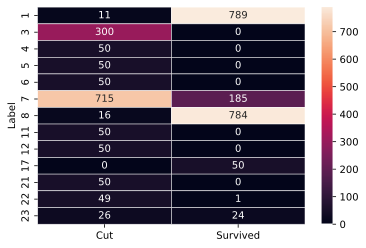

In [53]:
import seaborn as sns

labels = np.unique(dh_test.get('events', 'labels')[0])

ax = sns.heatmap(confusion_matrix_squeeze, annot=True, fmt='d', linewidths=.5, xticklabels=['Cut','Survived'], yticklabels=labels)
plt.ylabel("Label") 
plt.show()

Lets see how the standard event looks like, produced with the cnn cut.

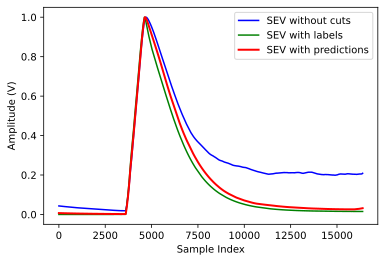

In [54]:
sev_raw = np.mean(dh_test.get('events', 'event')[0], axis=0)
sev_raw /= np.max(sev_raw)
sev_pred = np.mean(dh_test.get('events', 'event')[0, prediction == 1], axis=0)
sev_pred /= np.max(sev_pred)
sev_label = np.mean(dh_test.get('events', 'event')[0, y == 1], axis=0)
sev_label /= np.max(sev_label)

plt.plot(sev_raw, label='SEV without cuts', color='blue')
plt.plot(sev_label, label='SEV with labels', color='green')
plt.plot(sev_pred, label='SEV with predictions', color='red', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.show()

### Apply to real data

Here we show, how the model can be applied to another data set easily. During the training, we saved checkpoints with which the model can be realoaded at a later point. Now that we have the model already loaded in this notebook, we do not need to load it again. We can just apply the nn_predict function. 

In [55]:
# include the predictions in another HDF5 file
ai.models.nn_predict(h5_path='test_data/test_001.h5',
           model=cnn,
           feature_channel=0,
           group_name='events',
           prediction_name='cnn_cut',
           keys=['event'],
           no_channel_idx_in_pred=False)


cnn_cut written to file test_data/test_001.h5.


Because this is a multi-purpose model and probably useful in many situations, we stored it as a resource inside the library. So lets list all available resources:

In [8]:
ai.resources.list_resources()

Resources stored in /Users/felix/PycharmProjects/cait/cait/resources:
cnn-clf-binary-v1.ckpt
cnn-clf-binary-v0.ckpt


We have two different versions of this models stored, the v0 with 32 times downsampling, and the v1 with 4 time downsampling. Lets load and apply the v0 to the light channel (feature_channel 1).

In [56]:
ckp_path = ai.resources.get_resource_path('cnn-clf-binary-v0.ckpt')

ai.models.nn_predict(h5_path='test_data/test_001.h5',
           model=CNNModule.load_from_checkpoint(ckp_path),
           feature_channel=1,
           group_name='events',
           prediction_name='cnn_cut',
           keys=['event'],
           no_channel_idx_in_pred=False)


cnn_cut written to file test_data/test_001.h5.


Lets see the predictions inside the HDF5 set of with a DataHandler.

In [10]:
dh_real = ai.DataHandler(channels=[0,1])
dh_real.set_filepath(path_h5='test_data/',
                fname='test_001',
                appendix=False)

DataHandler Instance created.


For the phonon channel we expect only pulse events (1).

In [12]:
dh_real.get('events', 'cnn_cut')[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

For the light channel, we expect pulse and noise events (0,1).

In [14]:
dh_real.get('events', 'cnn_cut')[1]

array([0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 0.])

Done.